# Example to export a Keras trained model into the BioImage Model Zoo format using pydeepimagej
---
## Introduction
In this example we use a deep learning keras model trained using the steps in the notebook: https://bioimage.io/#/?type=notebook&id=deepimagej%2Funet-pancreaticcellsegmentation


It's a model with the [U-Net](https://en.wikipedia.org/wiki/U-Net)-like architecture to segment cells in Phase Contrast Microscopy images. The stored checkpoint of the model contains only the trained weights so we will first, initilize the model architecture and then load the trained weights.

<figure>
<center>
<img src="https://drive.google.com/uc?id=1FqWGkD2Ta38qcs2FqjOxic-fwdMTcpdY" width="650">
</figure>

The resulting bioimage.io model will be exported into a zip file called `pancreatic.ph.unet.bioimage.io.model.zip`. 

You will find it in `/content/pancreatic.ph.unet.bioimage.io.model.zip`


**Authors**: [deepImageJ](https://deepimagej.github.io/deepimagej/index.html).


## Getting started
First, we make sure we are using Tensorflow version compatible with [DeepImageJ](https://deepimagej.github.io/deepimagej/index.html) (<= 1.15).


In [ ]:
%pip install pydeepimagej
# Use Tensorflow and Keras versions compatible with the model we want to lead. Note that deepImageJ only supports models from TensorFlow 1.
%tensorflow_version 1.x
# %pip install keras==2.2.4

In [ ]:
import tensorflow as tf
tf.__version__

# Load a trained model

## Initialize the U-Net architecture used for this model

In [ ]:
# Create U-Net for super-resolution
from keras.models import Model
from keras.layers import Input, UpSampling2D
from keras.layers import Dropout
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D
from keras.layers import concatenate

inputs = Input((None, None, 1))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = AveragePooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = AveragePooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = AveragePooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u5)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c2])
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.1) (c6)
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c1], axis=3)
c7 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.1) (c7)
c7 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c7)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()


## Download the checkpoint of the trained model

In [ ]:
!wget 'https://github.com/deepimagej/models/releases/download/0.3/unet_pancreatic_cell_segmentation.h5'

## Load the model

In [ ]:
model.load_weights('/content/unet_pancreatic_cell_segmentation.h5')

## Download the data that will be used as an example image

In [ ]:
!wget 'https://github.com/deepimagej/models/releases/download/0.3/PhC-C2DL-PSC.zip'
!unzip PhC-C2DL-PSC.zip

## Read an input image and process it

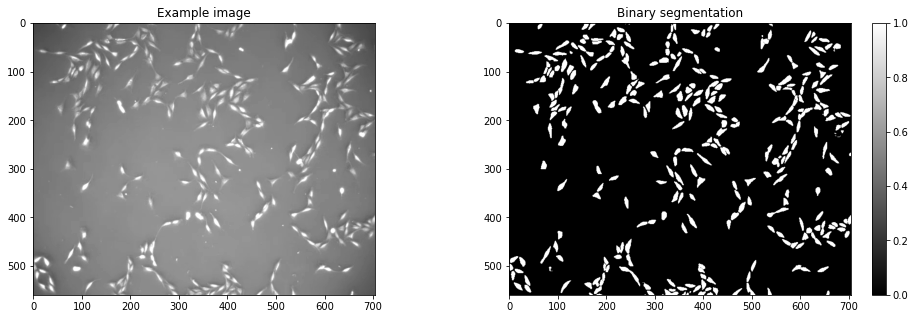

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
# ------------- User input ------------
threshold = 0.5
example_image_path = "/content/test/input/t234.tif"
# Read the input image
test_img = cv2.imread(example_image_path, cv2.IMREAD_ANYDEPTH)
# We crop the image to satisfy the input shape requirements of the network.
# The image can be also processed using tiles but we avoid that for simplicity.
test_img = test_img[:560,:704].astype(np.float32)
test_img /= np.max(test_img) # normalize between 0 and 1
# Prediction
test_mask = model.predict(np.expand_dims(test_img, axis=[0,-1]))
# Binarization
test_mask = (test_mask>threshold).astype(np.uint8)
test_mask = np.squeeze(test_mask)

# Display corresponding first 3 patches
plt.figure(figsize=(17,5))
plt.subplot(1, 2, 1)
plt.imshow( test_img, 'gray' )
plt.title( 'Example image' )

plt.subplot(1, 2, 2)
plt.imshow( test_mask, 'gray' )
plt.title('Binary segmentation')
plt.colorbar()
plt.show()

# Information about the images and their processing

# Set up the bioimage.io class

## Initilise BioImageConfig

In [ ]:
# import os
# os.chdir('/content/pydeepimagej-master')
from pydeepimagej.yaml import BioImageModelZooConfig
# os.chdir('/content/')

# Check minimum size: it is [8,8] for the 2D XY plane
pooling_steps = 0
for keras_layer in model.layers:
    if keras_layer.name.startswith('max') or "pool" in keras_layer.name:
      pooling_steps += 1
MinimumSize = [2**(pooling_steps), 2**(pooling_steps)]

dij_config = BioImageModelZooConfig(model, MinimumSize)

## Introduce the information about the model

In [ ]:
# ------------- User input ------------
# information about the model
dij_config.Name  = "Pancreatic Phase Contrast Cell Segmentation (U-Net)"
dij_config.Authors.Names = "[Ignacio Arganda-Carreras, DeepImageJ team]"
dij_config.Authors.Affiliations = "[EHU / UPV, UC3M / EPFL]"

dij_config.Description  = "DeepImageJ compatible U-Net trained to segment phase contrast microscopy images of pancreatic stem cells on a 2D polystyrene substrate."


dij_config.References = ["Falk et al. Nature Methods 2019",
                            "Ronneberger et al. arXiv in 2015",
                            "Gómez-de-Mariscal et al. biorXiv 2019"]
dij_config.DOI =  ["https://doi.org/10.1038/s41592-018-0261-2",
                     "https://doi.org/10.1007/978-3-319-24574-4_28",
                     "https://doi.org/10.1101/799270"]

dij_config.License = 'BSD-2'

dij_config.GitHub = "https://github.com/deepimagej/models/u-net_pancreatic_segmentation/"
dij_config.Documentation =  "https://github.com/deepimagej/models/u-net_pancreatic_segmentation/U_Net_PhC-C2DL-PSC_segmentation.ipynb"
dij_config.Tags = ["deepimagej", "pancreatic stem cells", "segmentation", "phase-contrast"]
dij_config.Framework = "tensorflow"


## Record the example image and minimal information about it.

In [ ]:
# Add the information about the test image. Note here PixelSize is given in nm
dij_config.add_test_info(test_img, test_mask, [1.6, 1.6])
dij_config.create_covers([test_img, test_mask])
dij_config.Covers =  ['./input.png', './output.png']

## Set up the pre- and post-processing steps and record them

In [ ]:
import urllib
# BioImage Model Zoo specifications for the pre- and post-processing
min_percentile=0
max_percentile=100
dij_config.BioImage_Postprocessing = None
dij_config.BioImage_Preprocessing = None
dij_config.add_bioimageio_spec('pre-processing', 'scale_range',
                               mode='per_sample', axes='xyzc',
                               min_percentile=min_percentile, 
                               max_percentile=max_percentile)

dij_config.add_bioimageio_spec('post-processing', 'binarize',
                               threshold=threshold)



# DeepImageJ macros to compute exactly that pre- and post-processings
## Prepare preprocessing file
path_preprocessing = "per_sample_scale_range.ijm"
urllib.request.urlretrieve('https://raw.githubusercontent.com/deepimagej/imagej-macros/master/bioimage.io/per_sample_scale_range.ijm', path_preprocessing )

# Modify the threshold in the macro to the chosen threshold
ijmacro = open(path_preprocessing,"r")  
list_of_lines = ijmacro. readlines()
# Line 21 is the one corresponding to the optimal threshold
list_of_lines[24] = "min_percentile = {};\n".format(min_percentile)
list_of_lines[25] = "max_percentile = {};\n".format(max_percentile)
ijmacro = open(path_preprocessing,"w")  
ijmacro. writelines(list_of_lines)
ijmacro. close()


## Prepare postprocessing file
path_postprocessing = "binarize.ijm"
urllib.request.urlretrieve('https://raw.githubusercontent.com/deepimagej/imagej-macros/master/bioimage.io/binarize.ijm', path_postprocessing )

# Modify the threshold in the macro to the chosen threshold
ijmacro = open(path_postprocessing,"r")  
list_of_lines = ijmacro. readlines()
# Line 21 is the one corresponding to the optimal threshold
list_of_lines[11] = "optimalThreshold = {};\n".format(threshold)
ijmacro.close()
ijmacro = open(path_postprocessing,"w")  
ijmacro. writelines(list_of_lines)
ijmacro. close()

# Include the info about the macros 
dij_config.Preprocessing = [path_preprocessing]
dij_config.Preprocessing_files = [path_preprocessing]

dij_config.Postprocessing = [path_postprocessing]
dij_config.Postprocessing_files = [path_postprocessing]


## Record the weights according to the format and any pretraining information


In [ ]:
# Store the model weights
# ---------------------------------------
dij_config.Parent = "https://bioimage.io/#/?id=deepimagej%2FUNet2DPancreaticSegmentation"

# Add weights information
format_authors = ["pydeepimagej"]
dij_config.add_weights_formats(model, 'TensorFlow', 
                               parent="keras_hdf5",
                               authors=[a for a in format_authors])
dij_config.add_weights_formats(model, 'KerasHDF5', 
                               authors=[a for a in format_authors])

## Export the model

In [ ]:
## EXPORT THE MODEL
import os
deepimagej_model_path = '/content/pancreatic.ph.unet.bioimage.io.model/'
if not os.path.exists(deepimagej_model_path):
  os.mkdir(deepimagej_model_path)
dij_config.export_model(deepimagej_model_path)
